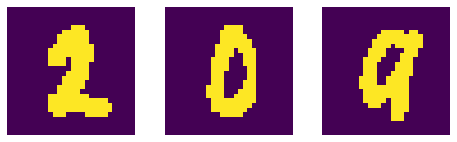

In [3]:
import os
import mindspore.dataset as ds   # 数据集的载入
import matplotlib.pyplot as plt

dataset_dir = "./MNIST/train"  # 数据集路径

# 从mnist dataset读取3张图片
mnist_dataset = ds.MnistDataset(dataset_dir=dataset_dir, num_samples=3)

# 设置图像大小
plt.figure(figsize=(8,8))
i = 1

# 打印3张子图
for dic in mnist_dataset.create_dict_iterator(output_numpy=True):
    plt.subplot(3,3,i)
    plt.imshow(dic['image'][:,:,0])
    plt.axis('off')
    i +=1
plt.show() 

In [5]:
import mindspore.dataset.transforms.c_transforms as C # 常用转化算子
import mindspore.dataset.vision.c_transforms as CV # 图像转化算子
from mindspore.common import dtype as mstype # 数据形态转换
from mindspore.common.initializer import Normal # 参数初始化

def create_dataset(data_path, batch_size=32):
    """ 
    数据预处理与批量输出的函数
    
    Args:
        data_path: 数据路径
        batch_size: 批量大小
    """
    
    # 加载数据集
    data = ds.MnistDataset(data_path)
    
    # 打乱数据集
    data = data.shuffle(buffer_size=10000)
    
    # 数据标准化参数
    # MNIST数据集的 mean = 33.3285，std = 78.5655
    mean, std = 33.3285, 78.5655 

    # 定义算子
    nml_op = lambda x : np.float32((x-mean)/std) # 数据标准化，image = (image-mean)/std
    hwc2chw_op = CV.HWC2CHW() # 通道前移（为配适网络，CHW的格式可最佳发挥昇腾芯片算力）
    type_cast_op = C.TypeCast(mstype.int32) # 原始数据的标签是unint，计算损失需要int

    # 算子运算
    data = data.map(operations=type_cast_op, input_columns='label')
    data = data.map(operations=nml_op, input_columns='image')
    data = data.map(operations=hwc2chw_op, input_columns='image')

    # 批处理
    data = data.batch(batch_size)
    
    # 重复
    data = data.repeat(1)

    return data

train_path = os.path.join('MNIST','train') # 训练集路径
train_data = create_dataset(train_path) # 定义训练数据集

test_path = os.path.join('MNIST','test') # 测试集路径
test_data = create_dataset(test_path) # 定义测试数据集 